In [1]:
import numpy as np
from skimage import io
from utils import grainPreprocess, grainMark

from matplotlib import pyplot as plt

from skimage import io, color, filters, morphology, util
from skimage.measure import EllipseModel
from skimage.color import rgb2gray
from skimage import filters, util
from skimage.morphology import disk, skeletonize, ball
from skimage.measure import approximate_polygon
from skimage import transform
import copy
from PIL import Image, ImageDraw, ImageFilter, ImageOps

from matplotlib import cm
import networkx as nx

In [2]:
def preprocess_image(image):
    if len(image.shape)==3:
        image = color.rgb2gray(image)

    image = filters.rank.median(image, morphology.disk(3))

    global_thresh = filters.threshold_otsu(image)
    image = image > global_thresh
    binary = image*255
    binary = binary.astype(np.uint8)

    grad = abs(filters.rank.gradient(binary, morphology.disk(1)))
    bin_grad = (1 - binary + grad) * 127
    bin_grad = np.clip(bin_grad, 0, 255).astype(np.uint8)

    return bin_grad

In [3]:
def draw_edges(image, cnts, color=(0, 139, 139), r=4, e_width=5, l_width=4):

    img = copy.copy(image)
    draw = ImageDraw.Draw(img)

    for j, cnt in enumerate(cnts):
        if len(cnt) > 1:
            point = cnt[0]
            x1, y1 = point[1], point[0]

            for i, point2 in enumerate(cnt):
                p2 = point2

                x2, y2 = p2[1], p2[0]

                draw.ellipse((y2 - r, x2 - r, y2 + r, x2 + r), fill=color, width=e_width)
                draw.line((y1, x1, y2, x2), fill=(255, 140, 0), width=l_width)
                x1, y1 = x2, y2

    return img

# Plot all points

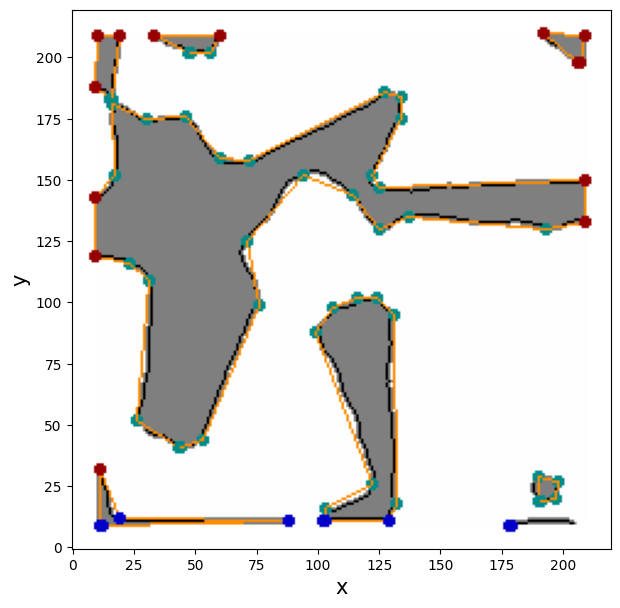

In [17]:
img = io.imread('../datasets/original/o_bc_left/Ultra_Co6_2/Ultra_Co6_2-001.jpeg')[:200,:200]
img = preprocess_image(img)
# img = 255 - img

r=2
eps = 15
border = 10
tol = 3

img_with_border = Image.fromarray(img)
img_with_border = ImageOps.expand(img_with_border, border=border, fill='white')

cnts=grainMark.get_contours(np.array(img_with_border),tol=tol)

# entry points
x_entry=[]
y_entry=[]

entry_dict={}

y_entry_max=0

for points in cnts:
    for point in points:
        if point[1]<eps:
            x,y = point[0],point[1]
            x_entry.append(x)
            y_entry.append(y)   
            # condition to make end exit poits below start points 
            if y_entry_max<y:
                y_entry_max=y
            
            entry_dict[str(f'{x}:{y}')]=1

# exit points
width, height=img_with_border.size     

x_exit=[]
y_exit=[]
exit_dict={}

for points in cnts:
    for point in points:
        if (point[0] < eps or width - point[0] < eps or height - point[1] < eps) and point[1]>y_entry_max:
            x,y = point[0],point[1]
            x_exit.append(x)
            y_exit.append(y)
            exit_dict[str(f'{x}:{y}')]=1

img = copy.copy(img_with_border).convert('RGB')
img=draw_edges(img, cnts=cnts, r=2, l_width=1)
draw = ImageDraw.Draw(img)


# blue
for i in range(len(x_entry)):
    x = x_entry[i]
    y = y_entry[i]
    draw.ellipse((x - r, y - r, x + r, y + r), fill=(0,0,200), width=1)
    
# red
for i in range(len(x_exit)):
    x = x_exit[i]
    y = y_exit[i]
    draw.ellipse((x - r, y - r, x + r, y + r), fill=(150,0,0), width=1)

plt.figure(figsize=(7,7))
plt.imshow(img,cmap='gray', origin='lower')
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)
plt.show()

Entry points 22
number of nodes 1770

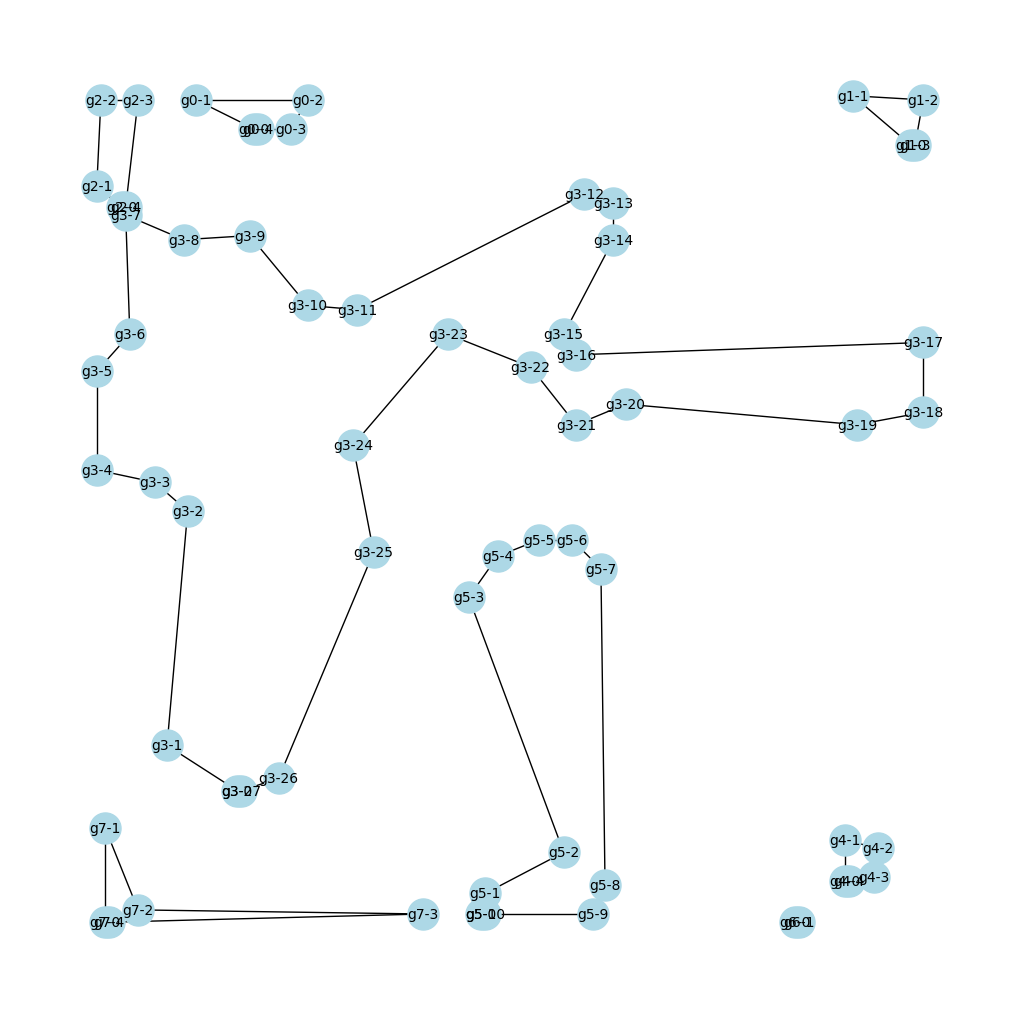

In [8]:
# contour_points = cnts[3]
gs=[]


for i,contour_points in enumerate(cnts):
    g = nx.Graph()

    for i, point in enumerate(contour_points):
        g.add_node(i, pos=point)


    for i in range(len(contour_points) - 1):
        g.add_edge(i, i + 1)

    g.add_edge(len(contour_points) - 1, 0)
    gs.append(g)

names = tuple([f"g{i}-" for i in range(len(cnts))])

g=nx.union_all(gs,rename=names)

pos = nx.get_node_attributes(g, 'pos')

plt.figure(figsize = (10,10))
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()

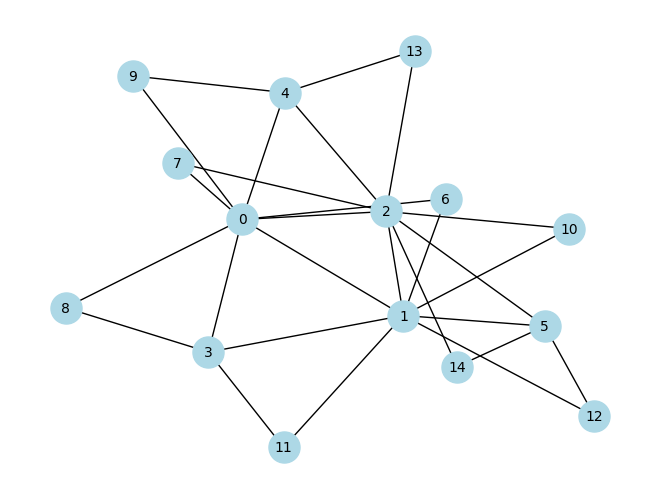

In [7]:
G = nx.dorogovtsev_goltsev_mendes_graph(3)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [10]:
# G = nx.path_graph(5)

# input 22 points
# output 66 points
# G = nx.complete_multipartite_graph(4,5)
G = nx.dorogovtsev_goltsev_mendes_graph(7)
# nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

G.number_of_nodes()

1095

In [11]:
%%time

list(nx.all_simple_paths(G, source=0, target=7))

KeyboardInterrupt: 